In [1]:
import jax

jax.config.update("jax_enable_x64", True)

In [2]:
literature_period = 2.46113408
literature_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
literature_flux_ratio = (0.354, 0.035)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
exposure = hdr["FRAMETIM"] * hdr["NUM_FRM"]
exposure /= 60.0 * 60.0 * 24.0

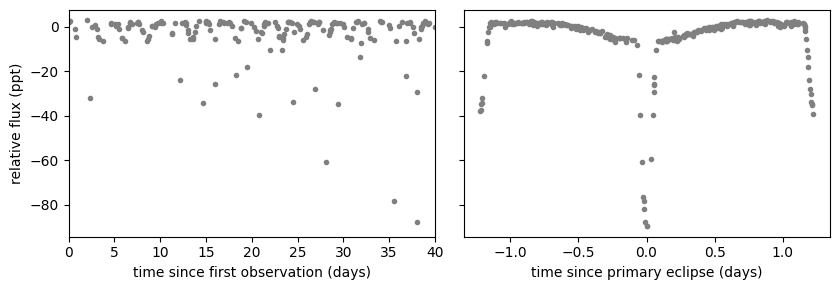

In [4]:
# To keep things fast for this example, we're only going to use a third of the data
np.random.seed(68594)
m = np.random.rand(len(lc.time)) < 1.0 / 10

time = lc.time.value[m]
flux = lc.flux[m]
flux = flux / np.median(flux) - 1
flux = flux.value

phase = (
    time - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)

plt.subplot(121)
plt.plot(time - time.min(), flux * 1000, ".", c="0.5")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase, flux * 1000, ".", c="0.5")
plt.xlabel("time since primary eclipse (days)")

plt.tight_layout()

In [5]:
from jaxoplanet.orbits.keplerian import System, Body, Central
from jaxoplanet.starry.orbit import SurfaceSystem, Surface
from jaxoplanet.starry.light_curves import light_curve
from jaxoplanet.light_curves.transforms import integrate
from jaxoplanet.units import unit_registry as ureg

In [6]:
from tinygp import GaussianProcess, kernels

In [7]:
import jax
import jax.numpy as jnp

params = {
    "primary_mass": 2.24,
    "secondary_mass": 1.570,
    "primary_radius": 1.758,
    "secondary_radius": 1.508,
    "inclination": 1.365,
    "eccentricity": 0.0,
    "omega": 0.0,
    "period": literature_period,
    "t0": literature_t0,
    "s": literature_flux_ratio[0],
    "error": 1e-3,
    "lc_gp_omega": 2 * np.pi / literature_period,
    "lc_gp_quality": 1.0,
    "lc_gp_sigma": 0.01,
    "mean_lc": 0.0,
    "jitter": 1.0,
}


def system_model(params):
    primary = Central(
        radius=params["primary_radius"] * ureg.R_sun,
        mass=params["primary_mass"] * ureg.M_sun,
    )

    primary_amplitude = 1.0
    primary_surface = Surface(
        u=(0.1, 0.1), amplitude=primary_amplitude, normalize=False
    )

    secondary = Body(
        radius=params["secondary_radius"] * ureg.R_sun,
        mass=params["secondary_mass"] * ureg.M_sun,
        period=params["period"] * ureg.day,
        time_transit=params["t0"] * ureg.day,
        eccentricity=params["eccentricity"],
        omega_peri=params["omega"] * ureg.rad,
        inclination=params["inclination"] * ureg.rad,
    )

    secondary_amplitude = params["s"]
    secondary_surface = Surface(
        u=(0.1, 0.1), amplitude=secondary_amplitude, normalize=False
    )

    system = SurfaceSystem(primary, primary_surface).add_body(
        secondary, secondary_surface
    )

    return system


def light_curve_model(time, params, y=None):

    def flux_function(time):
        flux = (
            jnp.sum(integrate(light_curve(system), exposure_time=exposure)(time))
        ) / (1 + params["s"]) - 1.0

        return flux

    gp = GaussianProcess(
        kernels.quasisep.SHO(
            sigma=params["lc_gp_sigma"],
            omega=params["lc_gp_omega"],
            quality=params["lc_gp_quality"],
        ),
        time,
        mean=flux_function,
        diag=(params["error"] * params["jitter"]) ** 2,
    )

    return gp.condition(y, time).gp.loc + params["mean_lc"]

NameError: name 'system' is not defined

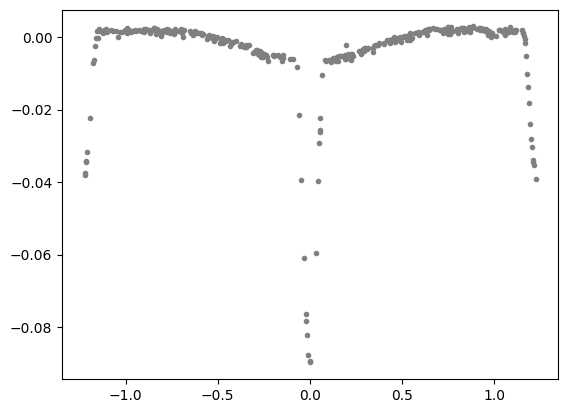

In [8]:
plt.plot(phase, flux, ".", c="0.5")
plt.plot(phase, light_curve_model(time, params, flux), ".")

In [ ]:
yerr = 1e-4

In [ ]:
from scipy.optimize import root
from scipy.special import gammaincc


def estimate_inverse_gamma_parameters(
    lower, upper, target=0.01, initial=None, **kwargs
):
    r"""Estimate an inverse Gamma with desired tail probabilities
    This method numerically solves for the parameters of an inverse Gamma
    distribution where the tails have a given probability. In other words
    :math:`P(x < \mathrm{lower}) = \mathrm{target}` and similarly for the
    upper bound. More information can be found in `part 4 of this blog post
    <https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html>`_.
    Args:
        lower (float): The location of the lower tail
        upper (float): The location of the upper tail
        target (float, optional): The desired tail probability
        initial (ndarray, optional): An initial guess for the parameters
            ``alpha`` and ``beta``
    Raises:
        RuntimeError: If the solver does not converge.
    Returns:
        dict: A dictionary with the keys ``alpha`` and ``beta`` for the
        parameters of the distribution.
    """
    lower, upper = np.sort([lower, upper])
    if initial is None:
        initial = np.array([2.0, 0.5 * (lower + upper)])
    if np.shape(initial) != (2,) or np.any(np.asarray(initial) <= 0.0):
        raise ValueError("invalid initial guess")

    def obj(x):
        a, b = np.exp(x)
        return np.array(
            [
                gammaincc(a, b / lower) - target,
                1 - gammaincc(a, b / upper) - target,
            ]
        )

    result = root(obj, np.log(initial), method="hybr", **kwargs)
    if not result.success:
        raise RuntimeError(
            "failed to find parameter estimates: \n{0}".format(result.message)
        )
    return dict(zip(("concentration", "rate"), np.exp(result.x)))

In [ ]:
estimate_inverse_gamma_parameters(0.1, 2.0)

{'concentration': 2.93853667764156, 'rate': 0.8301732325910088}

In [ ]:
import numpyro
import numpyro_ext
from numpyro.distributions import Normal, InverseGamma


def model(time, yerr, y=None):
    # Systemic parameters
    mean_lc = numpyro.sample("mean_lc", Normal(0.0, 5.0))

    # Parameters describing the primary
    log_M1 = numpyro.sample("log_M1", Normal(0.0, 10.0))
    log_R1 = numpyro.sample("log_R1", Normal(0.0, 10.0))
    M1 = numpyro.deterministic("primary_mass", jnp.exp(log_M1))
    R1 = numpyro.deterministic("primary_radius", jnp.exp(log_R1))

    # Secondary ratios
    log_radius_ratio = numpyro.sample("log_k", Normal(0.0, 10.0))  # radius ratio
    log_mass_ratio = numpyro.sample("log_q", Normal(0.0, 10.0))  # mass ratio
    log_flux_ratio = numpyro.sample("log_s", Normal(np.log(0.5), 10.0))  # flux ratio
    numpyro.deterministic("k", jnp.exp(log_radius_ratio))
    numpyro.deterministic("q", jnp.exp(log_mass_ratio))
    numpyro.deterministic("s", jnp.exp(log_flux_ratio))

    # Prior on flux ratio
    numpyro.sample(
        "flux_prior",
        Normal(*literature_flux_ratio),
        obs=jnp.exp(2 * log_radius_ratio + log_flux_ratio),
    )

    # Parameters describing the orbit
    log_period = numpyro.sample("log_period", Normal(np.log(literature_period), 1.0))
    period = numpyro.deterministic("period", jnp.exp(log_period))
    t0 = numpyro.sample("t0", Normal(literature_t0, 1.0))

    # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
    ecs = numpyro.sample("_", numpyro_ext.distributions.UnitDisk())
    ecc = numpyro.deterministic("eccentricity", jnp.sqrt(jnp.sum(ecs**2)))
    omega = numpyro.deterministic("omega", jnp.arctan2(ecs[1], ecs[0]))
    inclination = numpyro.sample("inclination", numpyro_ext.distributions.Angle())

    # Parameters describing the secondary
    R2 = numpyro.deterministic("secondary_radius", jnp.exp(log_radius_ratio + log_R1))
    M2 = numpyro.deterministic("secondary_mass", jnp.exp(log_mass_ratio + log_M1))

    jitter = numpyro.sample("jitter", Normal(1.0, 10.0))

    # gp
    lc_gp_omega = numpyro.deterministic("lc_gp_omega", 2 * np.pi / period)
    lc_gp_quality = numpyro.deterministic("lc_gp_quality", 1 / 3)
    lc_gp_sigma = numpyro.deterministic("lc_gp_sigma", 0.01)
    error = numpyro.deterministic("error", yerr)

    # lc_gp_omega = numpyro.sample(
    #     "lc_gp_omega", InverseGamma(**estimate_inverse_gamma_parameters(0.1, 5.0))
    # )
    # lc_gp_sigma = numpyro.sample(
    #     "lc_gp_sigma", InverseGamma(**estimate_inverse_gamma_parameters(0.1, 5.0))
    # )
    # lc_gp_quality = numpyro.deterministic("lc_gp_quality", 1 / 3)

    # # error
    # sigma_lc = numpyro.sample(
    #     "error", InverseGamma(**estimate_inverse_gamma_parameters(0.1, 2.0))
    # )

    model_params = {
        "primary_radius": R1,
        "primary_mass": M1,
        "secondary_mass": M2,
        "secondary_radius": R2,
        "eccentricity": ecc,
        "omega": omega,
        "inclination": inclination,
        "period": period,
        "t0": t0,
        "s": jnp.exp(log_flux_ratio),
        "error": yerr,
        "lc_gp_omega": lc_gp_omega,
        "lc_gp_quality": lc_gp_quality,
        "lc_gp_sigma": lc_gp_sigma,
        "jitter": jitter,
        "error": error,
    }

    y_pred = light_curve_model(time, model_params, y) + mean_lc
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr * jitter), obs=y)

In [9]:
init_sample = {
    "inclination": 1.5,
}

In [10]:
import numpyro_ext
import numpyro


run_optim = numpyro_ext.optim.optimize(
    model, init_strategy=numpyro.infer.init_to_value(values=params), sites=["jitter"]
)

NameError: name 'model' is not defined

In [11]:
params

{'primary_mass': 2.24,
 'secondary_mass': 1.57,
 'primary_radius': 1.758,
 'secondary_radius': 1.508,
 'inclination': 1.365,
 'eccentricity': 0.0,
 'omega': 0.0,
 'period': 2.46113408,
 't0': 2286.522069999948,
 's': 0.354,
 'error': 0.001,
 'lc_gp_omega': 2.5529634318742955,
 'lc_gp_quality': 1.0,
 'lc_gp_sigma': 0.01,
 'mean_lc': 0.0,
 'jitter': 1.0}

In [12]:
opt_params = run_optim(jax.random.PRNGKey(5), time, yerr, y=flux)

NameError: name 'run_optim' is not defined

In [13]:
opt_params

NameError: name 'opt_params' is not defined

NameError: name 'opt_params' is not defined

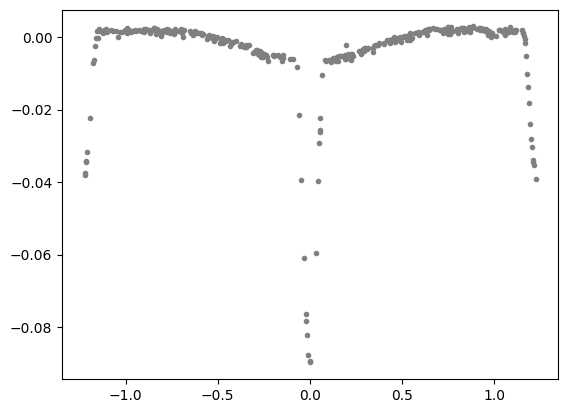

In [14]:
plt.plot(phase, flux, ".", c="0.5")
plt.plot(phase, light_curve_model(time, opt_params, flux), ".")

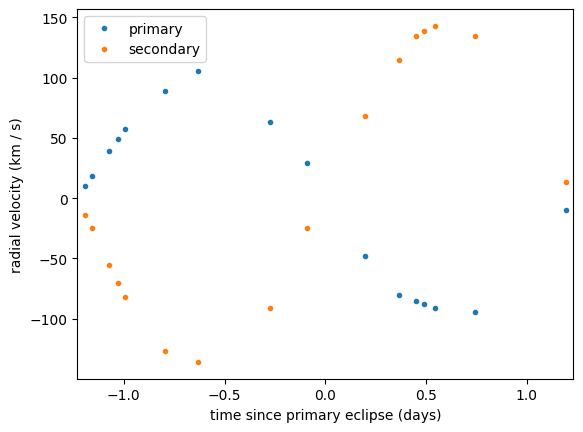

: 

In [203]:
ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

time_rvs = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
obs_rv1 = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
obs_rv2 = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

phase_rvs = (
    time_rvs - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period

plt.plot(phase_rvs, rvs[:, 1], ".", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * literature_period, 0.5 * literature_period)
plt.ylabel("radial velocity (km / s)")
_ = plt.xlabel("time since primary eclipse (days)")

In [16]:
params = {
    "primary_mass": 2.24,
    "secondary_mass": 1.570,
    "primary_radius": 1.758,
    "secondary_radius": 1.508,
    "inclination": 1.365,
    "eccentricity": 0.0,
    "omega": 0.0,
    "period": literature_period,
    "t0": literature_t0,
    "s": literature_flux_ratio[0],
    "error": 1e-3,
    "lc_gp_omega": 2 * np.pi / literature_period,
    "lc_gp_quality": 1.0,
    "lc_gp_sigma": 0.01,
    "mean_lc": 0.0,
    "jitter": 1.0,
    "mean_rv": 0.0,
}

In [81]:
from jaxoplanet.orbits import keplerian


def system_model(params):

    # from inferred parameters to system parameters
    R1 = jnp.exp(params["log_R1"]) * ureg.R_sun
    M1 = jnp.exp(params["log_M1"]) * ureg.M_sun
    R2 = jnp.exp(params["log_R1"] + params["log_k"]) * ureg.R_sun
    M2 = jnp.exp(params["log_M1"] + params["log_q"]) * ureg.M_sun
    period = jnp.exp(params["log_period"]) * ureg.day
    t0 = params["t0"] * ureg.day
    eccentricities = params["ecs"]
    eccentricity = jnp.sqrt(jnp.sum(eccentricities**2))
    omega = jnp.arctan2(eccentricities[1], eccentricities[0])
    inclination = params["inclination"] * ureg.rad

    primary = Central(radius=R1, mass=M1)

    system = keplerian.System(primary).add_body(
        radius=R2,
        mass=M2,
        period=period,
        time_transit=t0,
        eccentricity=eccentricity,
        omega_peri=omega,
        inclination=inclination,
    )

    return system


def rv_model(time, params):
    system = system_model(params)
    rv = system.radial_velocity(time)[0].to("km / s").magnitude
    mass_ratio = jnp.exp(params["log_q"])
    rv1 = 0 + rv
    rv2 = 0 - rv * mass_ratio
    return rv1, rv2

In [190]:
from jax import numpy as jnp
import numpyro
from numpyro.distributions import Normal


def model(time, rv1, rv2):
    # Parameters describing the primary
    log_M1 = numpyro.sample("log_M1", Normal(0.0, 10.0))
    log_R1 = numpyro.sample("log_R1", Normal(0.0, 10.0))

    # Secondary ratios
    log_radius_ratio = numpyro.sample("log_k", Normal(0.0, 10.0))  # radius ratio
    log_mass_ratio = numpyro.sample("log_q", Normal(0.0, 10.0))  # mass ratio
    log_flux_ratio = numpyro.sample("log_s", Normal(np.log(0.5), 10.0))  # flux ratio
    numpyro.deterministic("k", jnp.exp(log_radius_ratio))
    numpyro.deterministic("q", jnp.exp(log_mass_ratio))
    numpyro.deterministic("s", jnp.exp(log_flux_ratio))

    # Prior on flux ratio
    numpyro.sample(
        "flux_prior",
        Normal(*literature_flux_ratio),
        obs=jnp.exp(2 * log_radius_ratio + log_flux_ratio),
    )

    # Parameters describing the orbit
    log_period = numpyro.sample("log_period", Normal(np.log(literature_period), 1.0))
    t0 = numpyro.sample("t0", Normal(literature_t0, 200.0))

    # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
    ecs = numpyro.sample("ecs", numpyro_ext.distributions.UnitDisk())
    inclination = numpyro.sample("inclination", numpyro_ext.distributions.Angle())

    mean_rv = numpyro.sample("mean_rv", Normal(0.0, 10.0))

    model_params = {
        "log_M1": log_M1,
        "log_R1": log_R1,
        "log_q": log_mass_ratio,
        "log_k": log_radius_ratio,
        "log_period": log_period,
        "log_flux_ratio": log_flux_ratio,
        "inclination": inclination,
        "ecs": ecs,
        "log_s": log_flux_ratio,
        "t0": t0,
    }

    _rv1, _rv2 = rv_model(time, model_params)
    _rv1 += mean_rv
    _rv2 += mean_rv

    numpyro.sample("obs_rv1", numpyro.distributions.Normal(_rv1, 10), obs=rv1)
    numpyro.sample("obs_rv2", numpyro.distributions.Normal(_rv2, 10), obs=rv2)

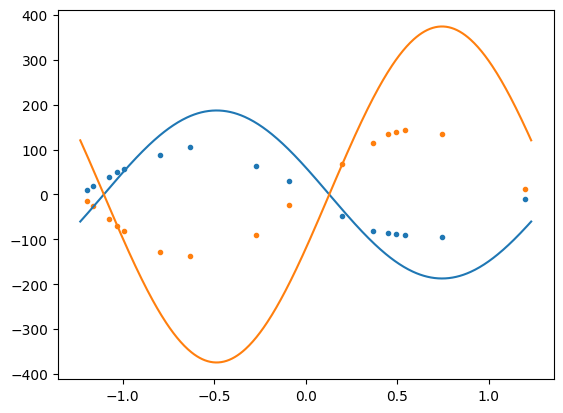

In [200]:
init_values = {
    "log_M1": np.log(2.0),
    "log_R1": np.log(2.0),
    "log_q": -np.log(0.5),
    "log_k": -np.log(1.0),
    "log_period": np.log(literature_period),
    "log_flux_ratio": np.log(0.5),
    "inclination": 1.365,
    "log_s": np.log(0.354),
    "t0": literature_t0,
    "ecs": np.array([1e-5, 0.0]),
}

import matplotlib.pyplot as plt

opt_params = init_values

# opt_params = params
period = jnp.exp(opt_params["log_period"])
t0 = opt_params["t0"]

x_phase = np.linspace(
    -0.5 * period,
    0.5 * period,
    500,
)
mrv1, mrv2 = rv_model(x_phase, opt_params)

phase_rvs = (time_rvs - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(phase_rvs, rvs[:, 1], ".", color="C0", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", color="C1", label="secondary")
plt.plot(x_phase, mrv1, "-", color="C0")
plt.plot(x_phase, mrv2, "-", color="C1")

In [201]:
import numpyro_ext
import numpyro

opt_params = numpyro_ext.optim.optimize(model, start=init_values)(
    jax.random.PRNGKey(0),
    time_rvs,
    rv1=rvs[:, 1],
    rv2=rvs[:, 2],
)

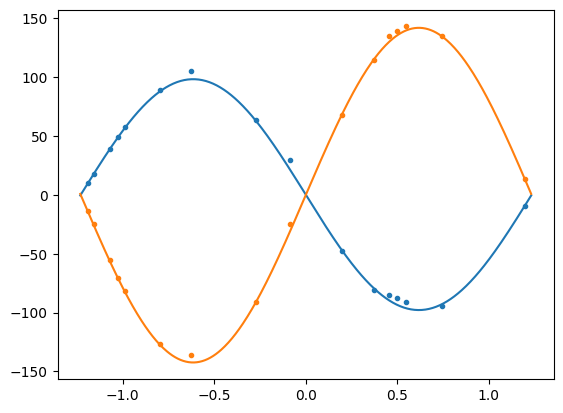

In [202]:
# opt_params = params
period = jnp.exp(opt_params["log_period"])
t0 = opt_params["t0"]

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
mrv1, mrv2 = rv_model(x_phase + t0, opt_params)

phase_rvs = (time_rvs - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(phase_rvs, rvs[:, 1], ".", color="C0", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", color="C1", label="secondary")
plt.plot(x_phase, mrv1, "-", color="C0")
plt.plot(x_phase, mrv2, "-", color="C1")

In [565]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
import pandas as pd

idl = readsav("/Users/lgarcia/Downloads/light_curve.sav")
df = pd.DataFrame(
    np.array(idl["light_curve"]).byteswap().newbyteorder(), columns=["time", "flux"]
)

In [427]:
# Calculate rolling median and standard deviation
df_med = df.rolling(5000, center=False).median()
df_std = df.rolling(5000, center=False).std()

# Calculate data uncertainties as the median rolling standard deviation
assumed_errors = np.nanmedian(df_std.flux)
df["std"] = pd.Series(assumed_errors * np.ones(len(df.flux)), index=df.index)

time = df["time"].values
y = df["flux"].values
yerr = df["std"].values

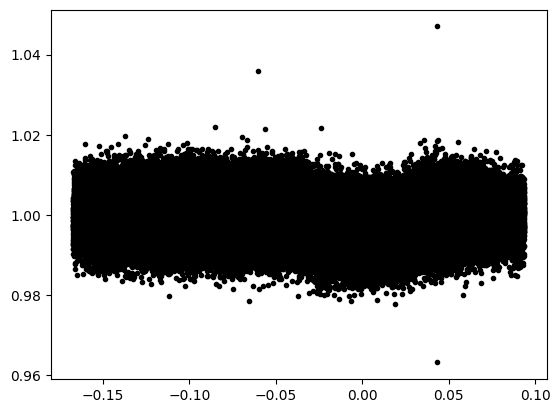

In [ ]:
plt.plot(time, y, "k.")

NameError: name 'self' is not defined

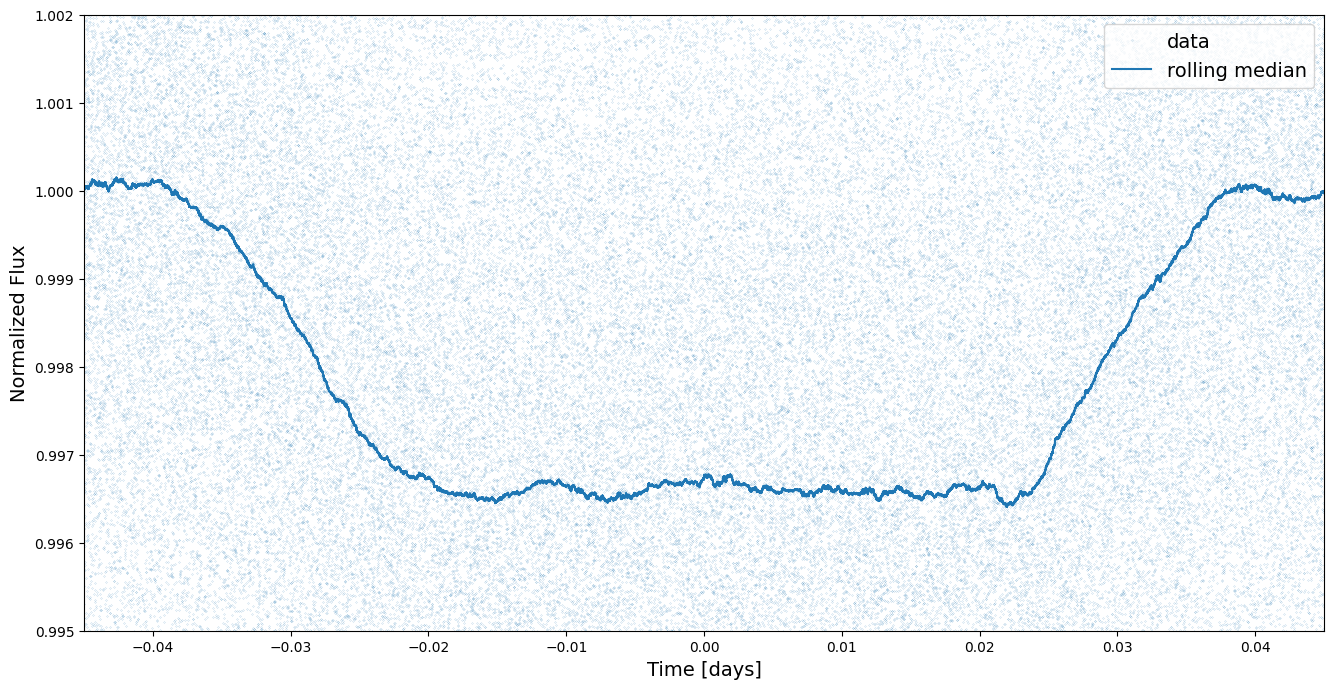

In [ ]:
# Mask phasecurve
tstart = 0.045
mask = (time > -tstart) & (time < tstart)

if True:

    # Make plot
    fig, ax = plt.subplots(1, figsize=(16, 8))
    ax.plot(time, y, "o", alpha=1.0, ms=0.1, color="C0", label="data")
    ax.plot(df_med["time"], df_med["flux"], label="rolling median")
    ax.set_xlabel("Time [days]", fontsize=14)
    ax.set_ylabel("Normalized Flux", fontsize=14)
    ax.set_ylim(0.995, 1.002)
    ax.set_xlim(-tstart, tstart)
    ax.legend(fontsize=14, loc="upper right")

    # Save fig, ax as attributes
    self.fig = fig
    self.ax = ax

In [ ]:
time = time[mask]
y = y[mask]
yerr = yerr[mask]

In [ ]:
len(time)

127137